# House Prices: Advanced Regression Techniques

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold,RandomizedSearchCV

In [3]:
#Read in Files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (1460, 81)
Test shape:  (1459, 80)


In [ ]:
train['type'] = 1
test['type'] = 0

### Concatenate training and test features

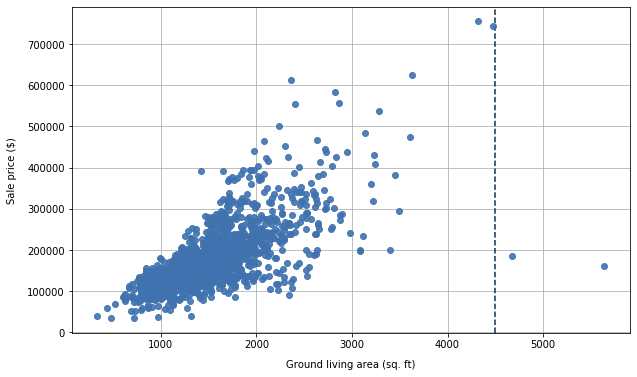

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.scatter(train["GrLivArea"], train["SalePrice"], c="#3f72af", zorder=3, alpha=0.9)
ax.axvline(4500, c="#112d4e", ls="--", zorder=2)
ax.set_xlabel("Ground living area (sq. ft)", labelpad=10)
ax.set_ylabel("Sale price ($)", labelpad=10)
plt.show()


In [6]:
train = train[train['GrLivArea'] < 4500]
X = pd.concat([train.drop('SalePrice', axis=1), test], sort=False)
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Transform target variable

In [7]:
y_train = np.log(train["SalePrice"])

### Handling Null values

In [ ]:
cleaning_null = X.isnull().sum().sort_values(ascending=False)

cleaning_null.head(50)

In [ ]:
# remove cols with more than 5% missing values
num_missing = X.isnull().sum()
drop_missing_cols = num_missing[(num_missing > len(X)/20)].sort_values()
X = X.drop(drop_missing_cols.index, axis=1)

In [ ]:
#Drop text cols with more than 25 missing values (25 picked after checking cols)
text_mv_counts = X.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
drop_missing_cols_2 = text_mv_counts[(text_mv_counts > 25)]
X = X.drop(drop_missing_cols_2.index, axis=1)

In [ ]:
#Text columns: For columns with missing values, fill in with the most common value in that column
text = X.select_dtypes(include=['object']).columns
for col in text:
    X[col] = X[col].fillna(X[col].value_counts().idxmax())
        
#Convert MSSubClass to a categorical rather than numerical
cols = ['MSSubClass', 'YrSold']
X[cols] = X[cols].astype("category")

In [8]:
# Engineer features

X["TotalSF"] = X["GrLivArea"] + X["TotalBsmtSF"]
X["TotalPorchSF"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
X["TotalBath"] = X["FullBath"] + X["BsmtFullBath"] + 0.5 * (X["BsmtHalfBath"] + X["HalfBath"])

In [ ]:
# To better exploit any seasonality in SalePrice, we transform MoSold (which is a cyclical feature) using the method described here.
# http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
X["SinMoSold"] = np.sin(2 * np.pi * X["MoSold"] / 12)
X["CosMoSold"] = np.cos(2 * np.pi * X["MoSold"] / 12)
X = X.drop("MoSold", axis=1)

In [ ]:
#Numerical columns: For columns with missing values, fill in with the most common value in that column
num_missing = X.select_dtypes(np.number).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(X)/20) & (num_missing > 0)].sort_values()
replacement_values_dict = X[fixable_numeric_cols.index].mode().to_dict(orient='record',)[0]
X = X.fillna(replacement_values_dict)

In [ ]:
cols = X.select_dtypes(np.number).columns
cols = cols.drop('Id')

#Transform highly skewed features using boxcox1p and boxcox_normmax
skew = X.skew(numeric_only=True).abs()
cols = skew[skew > 1].index
for col in cols:
    X[col] = boxcox1p(X[col], boxcox_normmax(X[col] + 1))
        
# scale features using RobustScaler.
X[cols] = RobustScaler().fit_transform(X[cols])

In [ ]:
# Creating dummies for categorical data
X = pd.get_dummies(X)

In [ ]:
# Recover training and test features

X_train = X[X['type'] == 1]
X_train = X_train.drop(['Id','type'], axis=1)
X_test = X[X['type'] == 0]

X_test = X_test.drop('type', axis=1)

print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

# Concat SalesPrice with training features
train = pd.concat([X_train, y_train], axis=1)

# Export to csv
train.to_csv('train_cleaned.csv',index=False)
X_test.to_csv('holdout_cleaned.csv',index=False)

## Feature Selection And Engineering

In [9]:
train = pd.read_csv('train_cleaned.csv')
holdout = pd.read_csv('holdout_cleaned.csv')
train.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,-0.256404,7,5,2003,2003,1.090493,706.0,0.0,150.0,856.0,...,0,0,1,0,0,0,0,1,0,12.247694
1,0.035750,6,8,1976,1976,0.000000,978.0,0.0,284.0,1262.0,...,0,0,1,0,0,0,0,1,0,12.109011
2,0.403523,7,5,2001,2002,0.997099,486.0,0.0,434.0,920.0,...,0,0,1,0,0,0,0,1,0,12.317167
3,0.023729,7,5,1915,1970,0.000000,216.0,0.0,540.0,756.0,...,0,0,1,1,0,0,0,0,0,11.849398
4,0.962980,8,5,2000,2000,1.425556,655.0,0.0,490.0,1145.0,...,0,0,1,0,0,0,0,1,0,12.429216


In [ ]:
holdout.head()

## Remove outliers from training data

To remove outliers, we fit a linear model to the training data and remove examples with a studentized residual greater than 3.

In [ ]:
y_train = train['SalePrice']
X_train = train.drop('SalePrice', axis=1)
residuals = y_train - LinearRegression().fit(X_train, y_train).predict(X_train)
outliers = residuals[np.abs(zscore(residuals)) > 3].index
outliers

In [ ]:
train = train.drop(outliers)

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

kf = KFold(n_splits=5, random_state=0, shuffle=True)
model = GradientBoostingRegressor()


# n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
# max_features = ['auto', 'sqrt']
# max_depth = [2,3,5,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

random_grid = {'learning_rate': sp_randFloat(),
               'subsample'    : sp_randFloat(),
               'n_estimators' : sp_randInt(100, 1000),
               'max_depth'    : sp_randInt(4, 10) 
                 }

random_search = RandomizedSearchCV(estimator = model,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = kf,
                                   scoring = 'neg_root_mean_squared_error',
                                   n_jobs = -1,
                                   random_state=0,verbose=True
                                  )

random_search = random_search.fit(X_train, y_train)

print("Parameters of the best_estimator:")
print(random_search.best_params_)
print("Mean cross-validated RMSE of the best_estimator: {}".format(-random_search.best_score_))
model = random_search.best_estimator_
print("RMSE of the whole training set: {}".format(rmse(y_train, model.predict(X_train))))



NameError: name 'KFold' is not defined

In [11]:
# Model from the training set. Used to identify errors and see if the model is overfitting.
def train_and_test(df, model):
    split_row = int(df.shape[0] * 0.8)
    train = df[0:split_row]
    test = df[split_row:]
    
    #Select numerical columns
    numerical_train = df.select_dtypes(include=['float','int','uint8'])
    numerical_test = df.select_dtypes(include=['float','int','uint8'])
    
    #drop target column from df
    features = numerical_train.columns.drop('SalePrice')
    rf = model
    rf.fit(train[features], train['SalePrice'])
    predictions = rf.predict(test[features])
    
    msle = mean_squared_log_error(np.exp(test['SalePrice']), np.exp(predictions))
    rmsle = np.sqrt(msle)
    comp_df = {'prediction': np.exp(predictions),
          'SalePrice':np.exp(test['SalePrice'])}
    df = pd.DataFrame(comp_df)

    
    return rmsle
    
 
# df = train_and_test(train,model)
rmsle = train_and_test(train,model)
rmsle



NameError: name 'model' is not defined

In [ ]:
def train_test_submit(train_df, test_df, model, filename='submission_30.csv'):

    
    #Select numerical columns
    numerical_train = train_df.select_dtypes(include=['float','int','uint8'])
    
    #drop target column from df
    features = numerical_train.columns.drop('SalePrice')
    rf = model
    rf.fit(train_df[features], train_df['SalePrice'])
    predictions = rf.predict(test_df[features])
    
    holdout_ids = test_df["Id"]
    submission_df = {"Id": holdout_ids,
                 "SalePrice": np.exp(predictions)}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)
    
train_test_submit(train,holdout,model)